# Multiclass classification of erythemato-squamous diseases  from clinical and histopathological attributes

In this notebook, I conducted multiclass classification analysis of erythemato-squamous diseases from 12 clinical and 22 histopathological attributes using modern machine learning algorithms such as [Support Vector Machines (SVM)](http://scikit-learn.org/stable/modules/svm.html) ,  [Extra-Trees Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html ) , [Random Forest Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html "") , [XGBoost](http://xgboost.readthedocs.io/en/latest/) , and [Keras](https://keras.io/  "Keras") . SVM, extra-trees classifier, and random forest classifiers are implemented using sklearn. XGBoost model is built using Python API. Keras is running on [Tensorflow](https://www.tensorflow.org/). 

Data source: [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Dermatology "UC Irvine Machine Learning Repository") 

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import pygal  # Dynamic SVG charting library
import itertools
import numpy as np
from scipy.stats import norm
from sklearn import svm
from sklearn.model_selection import train_test_split, learning_curve, ShuffleSplit, KFold,cross_val_score
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, Imputer, scale, LabelEncoder
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import StratifiedKFold
from scipy.stats import randint, uniform
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
from IPython.display import SVG, HTML
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.pipeline import Pipeline

/home/baki/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/baki/.local/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
Using TensorFlow backend.


In [2]:
# Interactive pygal plot in notebook
html_pygal = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/pygal-tooltips.js"></script>
    <!-- ... -->
  </head>
  <body>
    <figure>
      {pygal_render}
    </figure>
  </body>
</html>
"""

In [3]:
def plot_confusion_matrix(cm, classes):    
    #This function prints and plots the confusion matrix.
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    mask = np.zeros_like(cm)
    mask[np.triu_indices_from(mask, k=1)] = True

    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,10))

    sns.set(font_scale=2)
    sns.heatmap(cm,  annot=True,xticklabels = classes, yticklabels = classes,
                mask=mask, linewidths=.5, square =True,  ax=ax1)
    ax1.set(xlabel='Predicted', ylabel='Actual')
    ax1.set_title('Confusion matrix', fontsize=30)
    sns.heatmap(cm_norm, annot=True,xticklabels = classes, yticklabels =False,
                mask=mask, linewidths=.5,square =True, ax=ax2)
    ax2.set(xlabel='Predicted')
    ax2.set_title('Normalized confusion matrix', fontsize=30)
    plt.tight_layout()

In [4]:
Attributes = ["Erythema" , "Scaling", "Sefinite borders", "Itching", "Koebner phenomenon", "Polygonal papules",
              "Follicular papules", "Oral mucosal_involvement", "Knee elbow involvement", "Scalp involvement",
              "Family history", "Melanin incontinence", "Eosinophils in the infiltrate", "PNL infiltrate",
              "Fibrosis of the papillary dermis", "Exocytosis", "acanthosis", "Hyperkeratosis", "Parakeratosis",
              "Clubbing of the rete ridges", "Elongation of the rete ridges",
              "Thinning of the suprapapillary epidermis", "Spongiform pustule", "Munro microabcess",
              "Focal hypergranulosis", "Disappearance of the granular layer", 
              "Vacuolisation and damage of basal layer", "Spongiosis", "Saw-tooth appearance of retes",
              "Follicular horn plug", "Perifollicular parakeratosis", "Inflammatory monoluclear inflitrate",
              "Band-like infiltrate", "Age", "Class"]
classes = ["Psoriasis", "Seboreic dermatitis", "Lichen planus", "Pityriasis rosea", "Cronic dermatitis",
           "Pityriasis rubra pilaris"]
df_raw = pd.read_csv('dermatology.data',header=None, names = Attributes)

In [5]:
df_raw.head(10)

,Erythema,Scaling,Sefinite borders,Itching,Koebner phenomenon,Polygonal papules,Follicular papules,Oral mucosal_involvement,Knee elbow involvement,Scalp involvement,...,Disappearance of the granular layer,Vacuolisation and damage of basal layer,Spongiosis,Saw-tooth appearance of retes,Follicular horn plug,Perifollicular parakeratosis,Inflammatory monoluclear inflitrate,Band-like infiltrate,Age,Class
0,2,2,0,3,0,0,0,0,1,0,...,0,0,3,0,0,0,1,0,55,2
1,3,3,3,2,1,0,0,0,1,1,...,0,0,0,0,0,0,1,0,8,1
2,2,1,2,3,1,3,0,3,0,0,...,0,2,3,2,0,0,2,3,26,3
3,2,2,2,0,0,0,0,0,3,2,...,3,0,0,0,0,0,3,0,40,1
4,2,3,2,2,2,2,0,2,0,0,...,2,3,2,3,0,0,2,3,45,3
5,2,3,2,0,0,0,0,0,0,0,...,0,0,2,0,0,0,1,0,41,2
6,2,1,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,18,5
7,2,2,3,3,3,3,0,2,0,0,...,2,2,3,2,0,0,3,3,57,3
8,2,2,1,0,2,0,0,0,0,0,...,0,0,2,0,0,0,2,0,22,4
9,2,2,1,0,1,0,0,0,0,0,...,0,0,2,0,0,0,2,0,30,4


In [6]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 35 columns):
Erythema                                    366 non-null int64
Scaling                                     366 non-null int64
Sefinite borders                            366 non-null int64
Itching                                     366 non-null int64
Koebner phenomenon                          366 non-null int64
Polygonal papules                           366 non-null int64
Follicular papules                          366 non-null int64
Oral mucosal_involvement                    366 non-null int64
Knee elbow involvement                      366 non-null int64
Scalp involvement                           366 non-null int64
Family history                              366 non-null int64
Melanin incontinence                        366 non-null int64
Eosinophils in the infiltrate               366 non-null int64
PNL infiltrate                              366 non-null int64
Fibrosis of t

In [7]:
df_raw["Age"].unique()

array(['55', '8', '26', '40', '45', '41', '18', '57', '22', '30', '20',
       '21', '10', '65', '38', '23', '17', '51', '42', '44', '33', '43',
       '50', '34', '?', '15', '46', '62', '35', '48', '12', '52', '60',
       '32', '19', '29', '25', '36', '13', '27', '31', '28', '64', '39',
       '47', '16', '0', '7', '70', '37', '61', '67', '56', '53', '24',
       '58', '49', '63', '68', '9', '75'], dtype=object)

In [8]:
df_raw[df_raw["Age"] =='?']

,Erythema,Scaling,Sefinite borders,Itching,Koebner phenomenon,Polygonal papules,Follicular papules,Oral mucosal_involvement,Knee elbow involvement,Scalp involvement,...,Disappearance of the granular layer,Vacuolisation and damage of basal layer,Spongiosis,Saw-tooth appearance of retes,Follicular horn plug,Perifollicular parakeratosis,Inflammatory monoluclear inflitrate,Band-like infiltrate,Age,Class
33,2,2,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,?,1
34,2,1,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,?,4
35,2,2,1,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,?,2
36,2,1,2,3,2,3,0,2,0,0,...,0,2,0,2,0,0,0,3,?,3
262,2,1,0,2,0,0,0,0,0,0,...,0,0,2,0,0,0,3,0,?,5
263,1,1,1,3,0,0,0,0,0,0,...,0,0,3,0,0,0,2,0,?,5
264,1,1,0,2,0,0,0,0,1,0,...,0,0,2,0,0,0,3,0,?,5
265,1,1,0,3,0,0,0,0,0,0,...,0,0,2,0,0,0,3,0,?,5


In [9]:
df_raw = df_raw.replace('?', np.nan)
#df_raw = df_raw.to_numeric(convert_numeric=True) #turn data into numeric type for computation
df_raw["Age"] = pd.to_numeric(df_raw["Age"], downcast='signed')

In [10]:
df_raw.isnull().sum()

Erythema                                    0
Scaling                                     0
Sefinite borders                            0
Itching                                     0
Koebner phenomenon                          0
Polygonal papules                           0
Follicular papules                          0
Oral mucosal_involvement                    0
Knee elbow involvement                      0
Scalp involvement                           0
Family history                              0
Melanin incontinence                        0
Eosinophils in the infiltrate               0
PNL infiltrate                              0
Fibrosis of the papillary dermis            0
Exocytosis                                  0
acanthosis                                  0
Hyperkeratosis                              0
Parakeratosis                               0
Clubbing of the rete ridges                 0
Elongation of the rete ridges               0
Thinning of the suprapapillary epi

# Missing-data imputation

In [11]:
# Remove Rows With Missing Values reached accuray 100%
#df_raw = df_raw.dropna(axis=0, how='any')
# Rreplace missing values with the mean value reached accuray 98.65%
#df_raw['Age'].fillna(df_raw['Age'].mean(), inplace=True)

# Rreplace missing values with the mode value reached accuray 98.65%
#df_raw['Age'] = pd.to_numeric( df_raw['Age'].fillna(df_raw['Age'].mode().mean()), downcast='signed')
# Rreplace missing values with the median value reached accuray 98.65%
df_filled = df_raw
df_filled['Age'] = pd.to_numeric(df_filled['Age'].fillna(df_filled['Age'].median()), downcast='signed')

In [12]:
pd.set_option('display.max_columns', None) 
df_filled.describe()

,Erythema,Scaling,Sefinite borders,Itching,Koebner phenomenon,Polygonal papules,Follicular papules,Oral mucosal_involvement,Knee elbow involvement,Scalp involvement,Family history,Melanin incontinence,Eosinophils in the infiltrate,PNL infiltrate,Fibrosis of the papillary dermis,Exocytosis,acanthosis,Hyperkeratosis,Parakeratosis,Clubbing of the rete ridges,Elongation of the rete ridges,Thinning of the suprapapillary epidermis,Spongiform pustule,Munro microabcess,Focal hypergranulosis,Disappearance of the granular layer,Vacuolisation and damage of basal layer,Spongiosis,Saw-tooth appearance of retes,Follicular horn plug,Perifollicular parakeratosis,Inflammatory monoluclear inflitrate,Band-like infiltrate,Age,Class
count,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,2.068306,1.795082,1.549180,1.366120,0.633880,0.448087,0.166667,0.377049,0.614754,0.519126,0.125683,0.404372,0.139344,0.546448,0.336066,1.368852,1.956284,0.527322,1.289617,0.663934,0.991803,0.633880,0.295082,0.363388,0.393443,0.464481,0.456284,0.953552,0.453552,0.103825,0.114754,1.866120,0.554645,36.267760,2.803279
std,0.664753,0.701527,0.907525,1.138299,0.908016,0.957327,0.570588,0.834147,0.982979,0.905639,0.331946,0.869818,0.411790,0.815451,0.853139,1.104418,0.712512,0.757116,0.917562,1.056829,1.162161,1.034924,0.670578,0.759721,0.849406,0.864899,0.954873,1.130172,0.954744,0.450433,0.488723,0.726108,1.105908,15.156875,1.597803
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,25.000000,1.000000
50%,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,35.000000,3.000000
75%,2.000000,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,2.000000,0.000000,48.000000,4.000000
max,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,1.000000,3.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,75.000000,6.000000


# Explanatory visualizations

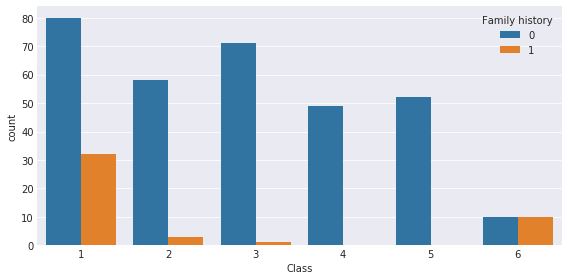

In [13]:
plt.figure(figsize=(8,4)) 
ax = sns.countplot(x='Class',hue="Family history", data=df_filled)
#ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()

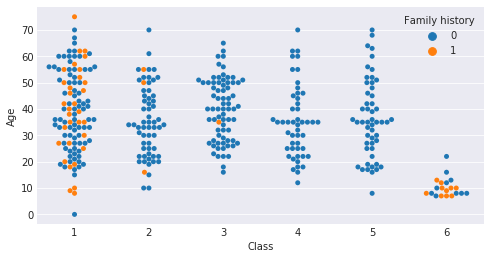

In [14]:
plt.figure(figsize=(8,4)) 
sns.swarmplot(x="Class", y="Age",hue="Family history", data=df_filled);

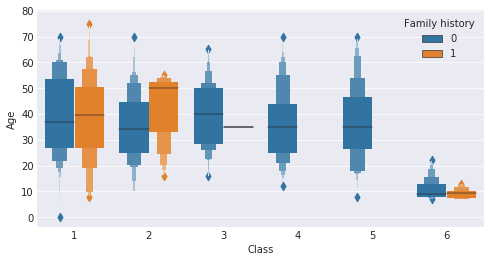

In [15]:
plt.figure(figsize=(8,4)) 
ax = sns.lvplot(x='Class',y = 'Age', hue="Family history", data=df_filled)

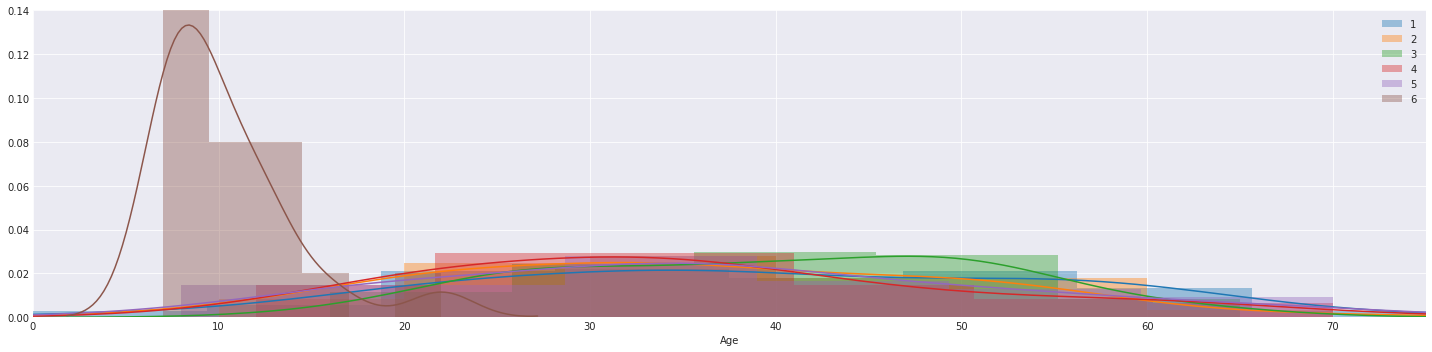

In [16]:
#Stratified
plt.figure(figsize=(8,6)) 
facet = sns.FacetGrid(df_filled, hue='Class',aspect=4, size=5)
facet.map(sns.distplot,'Age')
facet.set(xlim=(0, df_raw['Age'].max()))
#facet.set(ylim=(0, df_raw['Class'].max()))
plt.legend(loc='upper right')
#facet.add_legend()

In [17]:

unique_class = sorted(df_raw["Class"].unique())
unique_age = sorted(df_raw["Age"].unique())
df_percent= pd.DataFrame(columns=unique_class)

for i in unique_class:
    sub_list ={}
    value_dict = df_raw[df_raw['Class']==i][['Age', 'Class']].groupby('Age')['Class'].value_counts()
    pd.concat([value_dict,value_dict], ignore_index=True, axis=1)
    #for idx, key in value_dict.iteritems():
        #sub_list[int(idx[0])] =key
    df_percent[i] = value_dict
df = pd.DataFrame.from_dict(df_percent)
df = df/len(df_filled)

In [18]:
#value_dict = pd.value_counts(df_raw[df_raw['Class'] == 1]['Age'].values, sort=False).to_frame()
new_series = df_filled[df_filled['Class']==1][['Age', 'Class']].groupby('Age')['Age'].value_counts()
new_series2 = df_filled[df_filled['Class']==2][['Age', 'Class']].groupby('Age')['Age'].value_counts()
new_series3 = df_filled[df_filled['Class']==3][['Age', 'Class']].groupby('Age')['Age'].value_counts()
new_series4 = df_filled[df_filled['Class']==4][['Age', 'Class']].groupby('Age')['Age'].value_counts()
new_series5 = df_filled[df_filled['Class']==5][['Age', 'Class']].groupby('Age')['Age'].value_counts()
new_series6 = df_filled[df_filled['Class']==6][['Age', 'Class']].groupby('Age')['Age'].value_counts()
new_df = pd.concat([new_series, new_series2, new_series3, new_series4, new_series5,
                    new_series4], ignore_index=True, axis=1).transpose()
new_df.columns = new_df.columns.droplevel()
new_df = new_df.fillna(0)

In [19]:
new_df.columns = new_df.columns.astype('int')

In [20]:
from pygal.style import DefaultStyle
line_chart = pygal.StackedLine(fill=True,x_label_rotation=45, style=DefaultStyle)
line_chart.title = 'Different Diseases in age disstribution '
line_chart.x_labels = map(str, new_df.columns)
line_chart.human_readable = True
line_chart.add('1', new_df.iloc[0,:])
line_chart.add('2', new_df.iloc[1,:])
line_chart.add('3', new_df.iloc[2,:])
line_chart.add('4', new_df.iloc[3,:])
line_chart.add('5', new_df.iloc[4,:])
line_chart.add('6', new_df.iloc[5,:])
HTML(html_pygal.format(pygal_render=line_chart.render(is_unicode=True)))

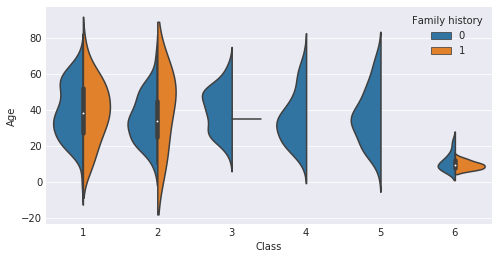

In [21]:
plt.figure(figsize=(8,4)) 
sns.violinplot(x="Class", y="Age",hue="Family history", data=df_filled, split=True);

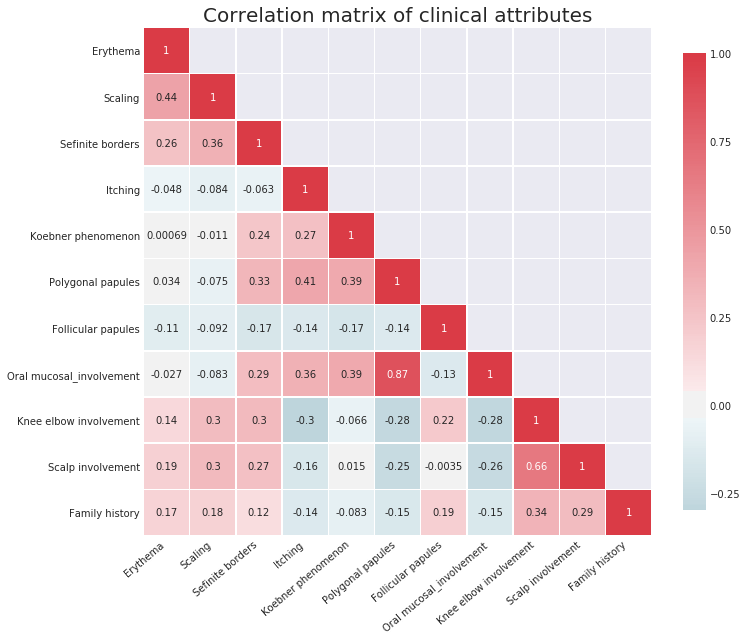

In [22]:
corr = df_filled.iloc[:,:11].corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask, k=1)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap,annot=True,  center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .9})
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title('Correlation matrix of clinical attributes', fontsize=20)
plt.tight_layout()

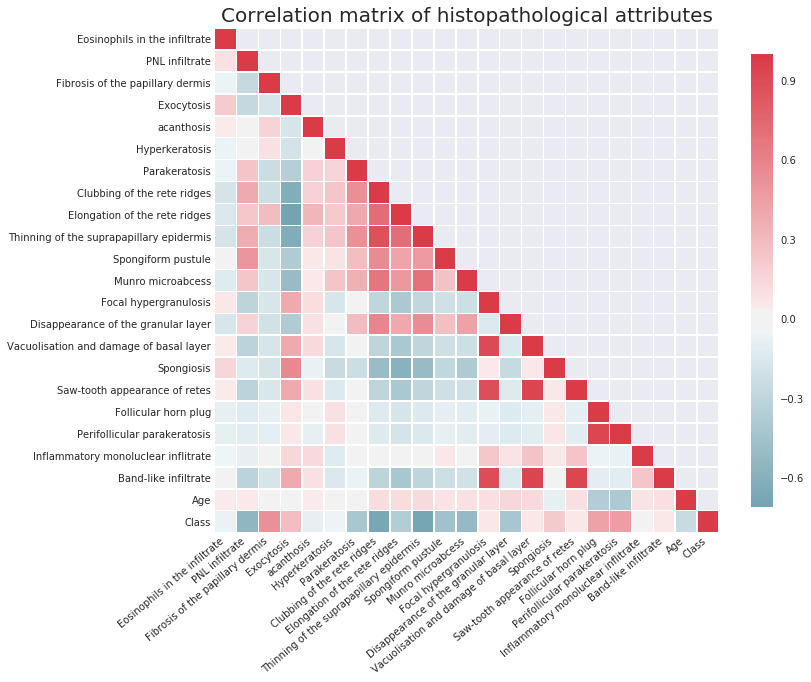

In [23]:
corr = df_filled.iloc[:,12:].corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask, k=1)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.set(font_scale=1)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .6})
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title('Correlation matrix of histopathological attributes', fontsize=20)
plt.tight_layout()

In [24]:
df_percent = {}
for i in Attributes[:10]:
    df_percent[i] = pd.value_counts(df_filled[i].values, sort=False).tolist()
df = pd.DataFrame.from_dict(df_percent)
df = df/len(df_filled)

In [25]:
line_chart  = pygal.StackedBar(x_label_rotation=45)                                   
line_chart .title = 'Clinical feature degree (in %)'
line_chart .x_labels = Attributes[:10]
line_chart .add('0', df.iloc[0,:]) 
line_chart .add('1', df.iloc[1,:]) 
line_chart .add('2', df.iloc[2,:]) 
line_chart .add('3', df.iloc[3,:])  
HTML(html_pygal.format(pygal_render=line_chart .render(is_unicode=True)))

In [26]:
df_percent = {}
for i in Attributes[11:-2]:
    sub_list =[0,0,0,0]
    value_dict = pd.value_counts(df_filled[i].values, sort=False).to_dict()
    for idx, key in value_dict.items():
        sub_list[idx] =key
    df_percent[i] = sub_list
df = pd.DataFrame.from_dict(df_percent)
df = df/len(df_filled)

line_chart  = pygal.StackedBar(x_label_rotation=45)                                   
line_chart .title = 'Histopathological attributes degree (in %)'
line_chart .x_labels = Attributes[11:-2]
line_chart .add('0', df.iloc[0,:]) 
line_chart .add('1', df.iloc[1,:]) 
line_chart .add('2', df.iloc[2,:]) 
line_chart .add('3', df.iloc[3,:])  
HTML(html_pygal.format(pygal_render=line_chart .render(is_unicode=True)))

# Data normalization

In [27]:
#Normalization
from sklearn import preprocessing
minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1))
df_norm = df_filled
df_norm.iloc[:,:-1] = minmax_scale.fit_transform(df_filled.iloc[:,:-1])

# Train test split

In [28]:
# Setting parameters
x_data, x_test_data, y_data, y_test_data = train_test_split(df_norm.iloc[:,:-1],df_norm.iloc[:,-1],test_size=0.2, random_state=123)
svm_para = [{'kernel':['rbf'],'C': [1,10,100,100]}]

# Support vector Machines (SVM)

In [29]:
classifier = GridSearchCV(svm.SVC(),svm_para,cv=3,verbose=2)
classifier.fit(x_data,y_data)
classifier.grid_scores_
classifier.best_params_

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] C=1, kernel=rbf .................................................
[CV] ........................................ C=1, kernel=rbf -   0.0s
[CV] C=1, kernel=rbf .................................................
[CV] ........................................ C=1, kernel=rbf -   0.0s
[CV] C=1, kernel=rbf .................................................
[CV] ........................................ C=1, kernel=rbf -   0.0s
[CV] C=10, kernel=rbf ................................................
[CV] ....................................... C=10, kernel=rbf -   0.0s
[CV] C=10, kernel=rbf ................................................
[CV] ....................................... C=10, kernel=rbf -   0.0s
[CV] C=10, kernel=rbf ................................................
[CV] ....................................... C=10, kernel=rbf -   0.0s
[CV] C=100, kernel=rbf ...............................................
[CV] ............

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished


{'C': 10, 'kernel': 'rbf'}

In [30]:
# Parameters optimized using the code in above cell
C_opt = 10 # reasonable option
clf = svm.SVC(C=C_opt,kernel='rbf')
clf.fit(x_data,y_data)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [31]:
y_pred = clf.predict(x_test_data)
accuracy = accuracy_score(y_test_data, y_pred);
print ('accuracy:%0.2f%%'%(accuracy*100))

accuracy:98.65%


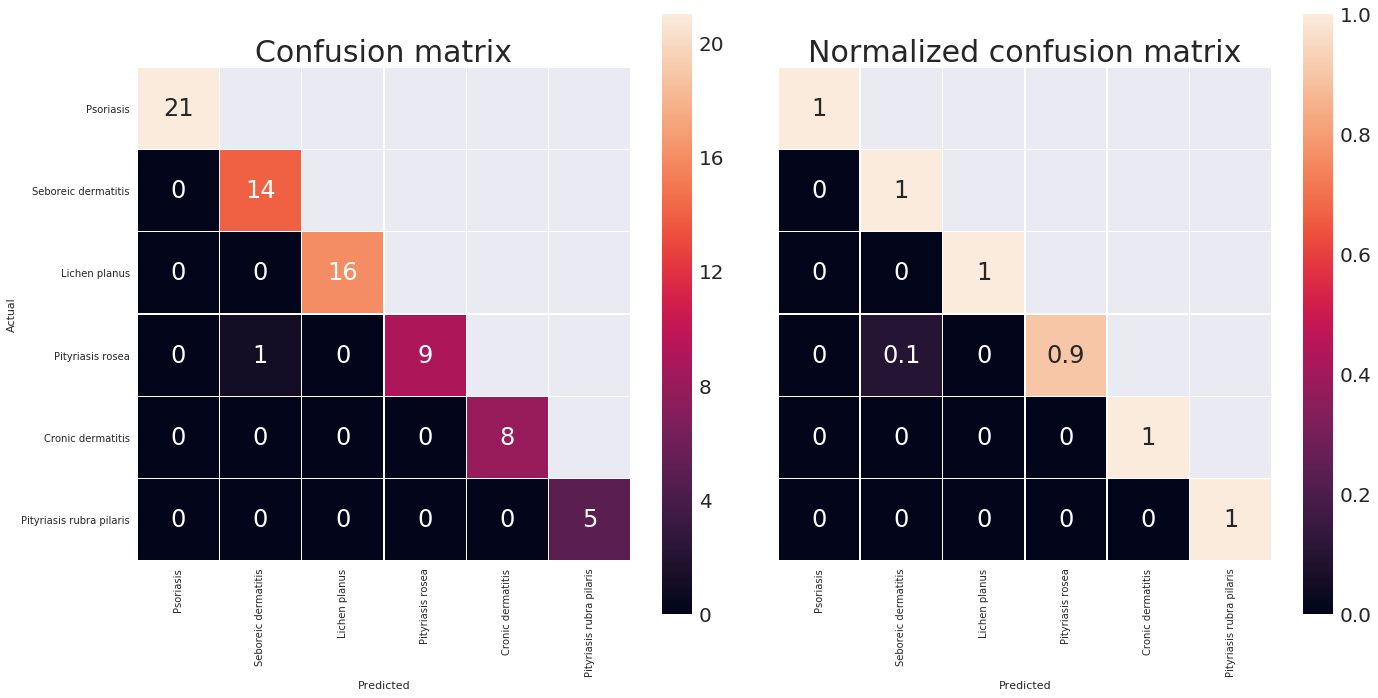

In [32]:
cnf_matrix = confusion_matrix(y_test_data, y_pred)
plot_confusion_matrix(cnf_matrix, classes=classes)

# ExtraTreesClassifier

In [33]:
etc_para = [{'n_estimators':[20,30,100, 200], 'max_depth':[5,10,15], 'max_features':[0.1,0.2,0.3, 0.4, 0.5]}] 

In [34]:
ETC = GridSearchCV(ExtraTreesClassifier(),param_grid=etc_para, cv=10, n_jobs=-1)
ETC.fit(x_data,y_data)
ETC.best_params_
#ETC.grid_scores_

{'max_depth': 15, 'max_features': 0.2, 'n_estimators': 200}

In [35]:
print ('Best accuracy obtained: {}'.format(ETC.best_score_))
print ('Parameters:')
for key, value in ETC.best_params_.items():
    print('\t{}:{}'.format(key,value))

Best accuracy obtained: 0.9931506849315068
Parameters:
	max_features:0.2
	n_estimators:200
	max_depth:15


In [36]:
# Classification Report
y_pred = ETC.predict(x_test_data)
print (classification_report(y_test_data, y_pred, target_names=classes))

                          precision    recall  f1-score   support

               Psoriasis       1.00      1.00      1.00        21
     Seboreic dermatitis       0.88      1.00      0.93        14
           Lichen planus       1.00      1.00      1.00        16
        Pityriasis rosea       1.00      0.80      0.89        10
       Cronic dermatitis       1.00      1.00      1.00         8
Pityriasis rubra pilaris       1.00      1.00      1.00         5

             avg / total       0.98      0.97      0.97        74



# Learning Curve

In [37]:
def plot_learning_curve(model,title, X, y,n_jobs = 1, ylim = None, cv = None,train_sizes = np.linspace(0.1, 1, 5)):
    
    # Figrue parameters
    plt.figure(figsize=(10,8))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training Examples')
    plt.ylabel('Score')
    
    train_sizes, train_score, test_score = learning_curve(model, X, y, cv = cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    # Calculate mean and std
    train_score_mean = np.mean(train_score, axis=1)
    train_score_std = np.std(train_score, axis=1)
    test_score_mean = np.mean(test_score, axis=1)
    test_score_std = np.std(test_score, axis=1)
    
    plt.grid()
    plt.fill_between(train_sizes, train_score_mean - train_score_std, train_score_mean + train_score_std,\
                    alpha = 0.1, color = 'r')
    plt.fill_between(train_sizes, test_score_mean - test_score_std, test_score_mean + test_score_std,\
                    alpha = 0.1, color = 'g')
    
    plt.plot(train_sizes, train_score_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_score_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.legend(loc = "best")
    return plt

In [38]:
# 'max_features': 0.4, 'n_estimators': 100, 'max_depth': 15, 'min_samples_leaf: 1'
etc = ExtraTreesClassifier(bootstrap=True, oob_score=True, n_estimators=100, max_depth=10, max_features=0.4, \
                           min_samples_leaf=1)

etc.fit(x_data, y_data)
y_pred = etc.predict(x_test_data)
accuracy = accuracy_score(y_test_data, y_pred);
print ('accuracy:%0.2f%%'%(accuracy*100))

accuracy:97.30%


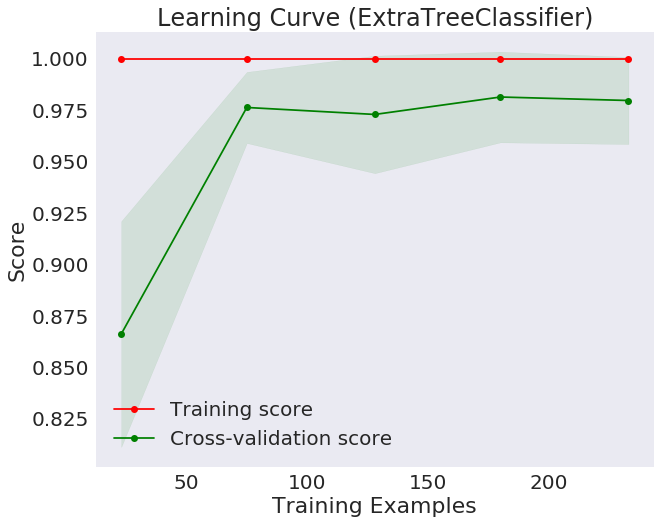

In [39]:
# Plotting learning curve
title = 'Learning Curve (ExtraTreeClassifier)'
# cross validation with 50 iterations to have a smoother curve
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
model = etc
plot_learning_curve(model,title,x_data, y_data, n_jobs=-1,ylim=None,cv=cv)
plt.show()

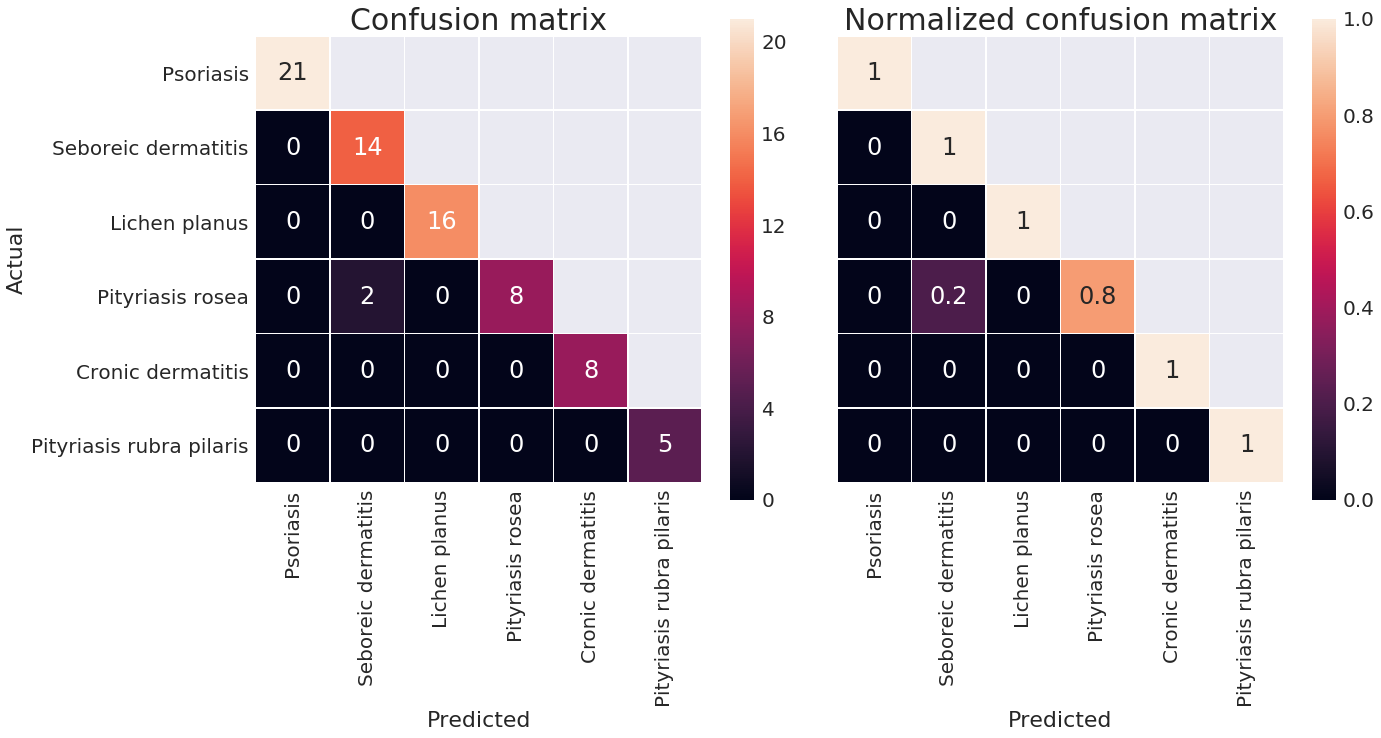

In [40]:
cnf_matrix = confusion_matrix(y_test_data,y_pred)
plot_confusion_matrix(cnf_matrix, classes=classes)

# Random Forest

In [41]:
rf_para = [{'n_estimators':[50, 100,150], 'max_depth':[5,10,15], 'max_features':[0.05, 0.1, 0.3], \
           'min_samples_leaf':[1,3], 'bootstrap':[True, False]}]
rfc = GridSearchCV(RandomForestClassifier(), param_grid=rf_para, cv = 10, n_jobs=-1)
rfc.fit(x_data, y_data)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'max_features': [0.05, 0.1, 0.3], 'n_estimators': [50, 100, 150], 'min_samples_leaf': [1, 3], 'max_depth': [5, 10, 15], 'bootstrap': [True, False]}],
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [42]:
print ('Best accuracy obtained: {}'.format(rfc.best_score_))
print ('Parameters:')
for key, value in rfc.best_params_.items():
    print('\t{}:{}'.format(key,value))

Best accuracy obtained: 0.9897260273972602
Parameters:
	max_features:0.1
	n_estimators:100
	min_samples_leaf:1
	max_depth:10
	bootstrap:True


In [43]:
RFC = RandomForestClassifier(n_estimators=100, max_depth=15, max_features=0.1, bootstrap=False, min_samples_leaf=1,\
                             n_jobs=1)
RFC.fit(x_data,y_data)
y_pred = RFC.predict(x_test_data)
accuracy = accuracy_score(y_test_data, y_pred);
print ('accuracy:%0.2f%%'%(accuracy*100))

accuracy:97.30%


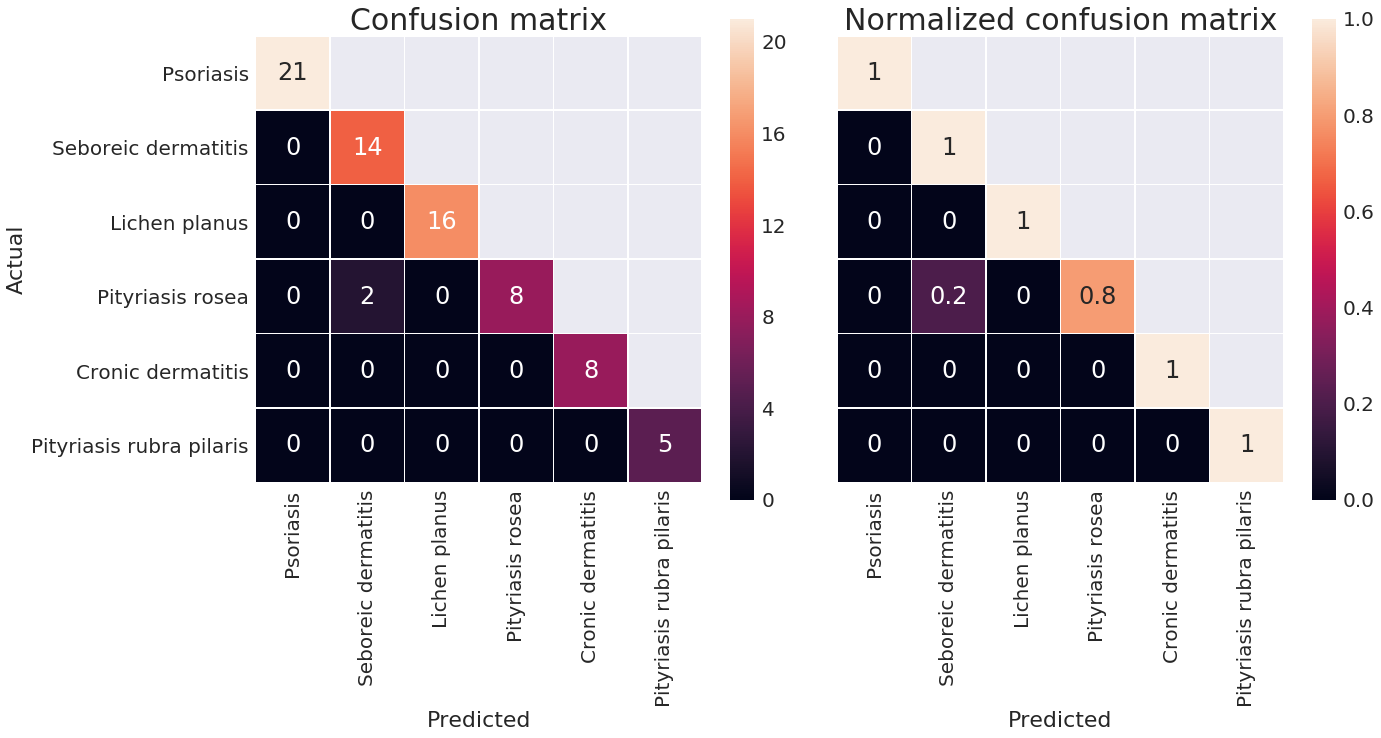

In [44]:
cnf_matrix = confusion_matrix(y_test_data, y_pred)
plot_confusion_matrix(cnf_matrix, classes=classes)

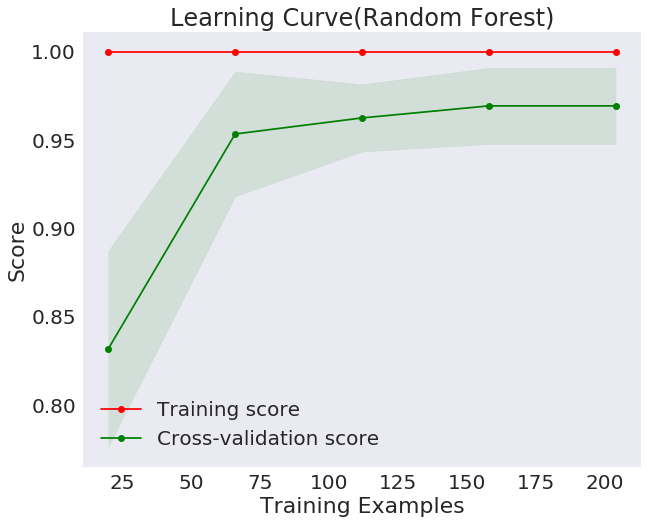

In [45]:
# Plotting Learning Curve
title = 'Learning Curve(Random Forest)'
model = RFC
cv = ShuffleSplit(n_splits=10, test_size=0.3,random_state=0)
plot_learning_curve(model,title,x_data,y_data, n_jobs=-1,ylim=None,cv=cv)
plt.show()

# Xgboost

In [46]:
cv = StratifiedKFold(y_data, n_folds=10, shuffle=True)

params_dist_grid = {
    'max_depth': [1,3, 5, 10],
    'gamma': [0, 0.5, 1],
    'n_estimators': randint(1, 1001), # uniform discrete random distribution
    'learning_rate': uniform(), # gaussian distribution
    'subsample': uniform(), # gaussian distribution
    'colsample_bytree': uniform(), # gaussian distribution
    'reg_lambda':uniform(),
    'reg_alpha':uniform()
    }

xgbc_fixed = {'booster':['gbtree'], 'silent':1}

In [47]:
bst_gridd = RandomizedSearchCV(estimator=XGBClassifier(*xgbc_fixed), param_distributions=params_dist_grid,\
                               scoring='accuracy', cv=cv, n_jobs=-1)

In [48]:
bst_gridd.fit(x_data,y_data)
bst_gridd.grid_scores_

print ('Best accuracy obtained: {}'.format(bst_gridd.best_score_))
print ('Parameters:')
for key, value in bst_gridd.best_params_.items():
    print('\t{}:{}'.format(key,value))

Best accuracy obtained: 0.9897260273972602
Parameters:
	subsample:0.771603831956309
	learning_rate:0.05907923991287145
	n_estimators:900
	max_depth:3
	colsample_bytree:0.015032446028428015
	gamma:0.5
	reg_lambda:0.014487782802798055
	reg_alpha:0.38858549261458186


In [49]:
eval_set = [(x_test_data, y_test_data)]

XGBC = XGBClassifier(silent=1,n_estimators=846,learning_rate=0.1214,max_depth=5,gamma=0,nthread=-1,\
                    reg_alpha = 0.15723254549975096, reg_lambda= 0.42827081493709585, max_delta_step = 1, \
                     subsample = 0.4318058788229575, colsample_bytree =0.024252612280742047)

In [50]:
XGBC.fit(x_data, y_data, early_stopping_rounds=100, eval_set=eval_set, eval_metric='merror', verbose=False)
y_pred = XGBC.predict(x_test_data)
accuracy = accuracy_score(y_test_data, y_pred);
print ('accuracy:%0.2f%%'%(accuracy*100))

accuracy:97.30%


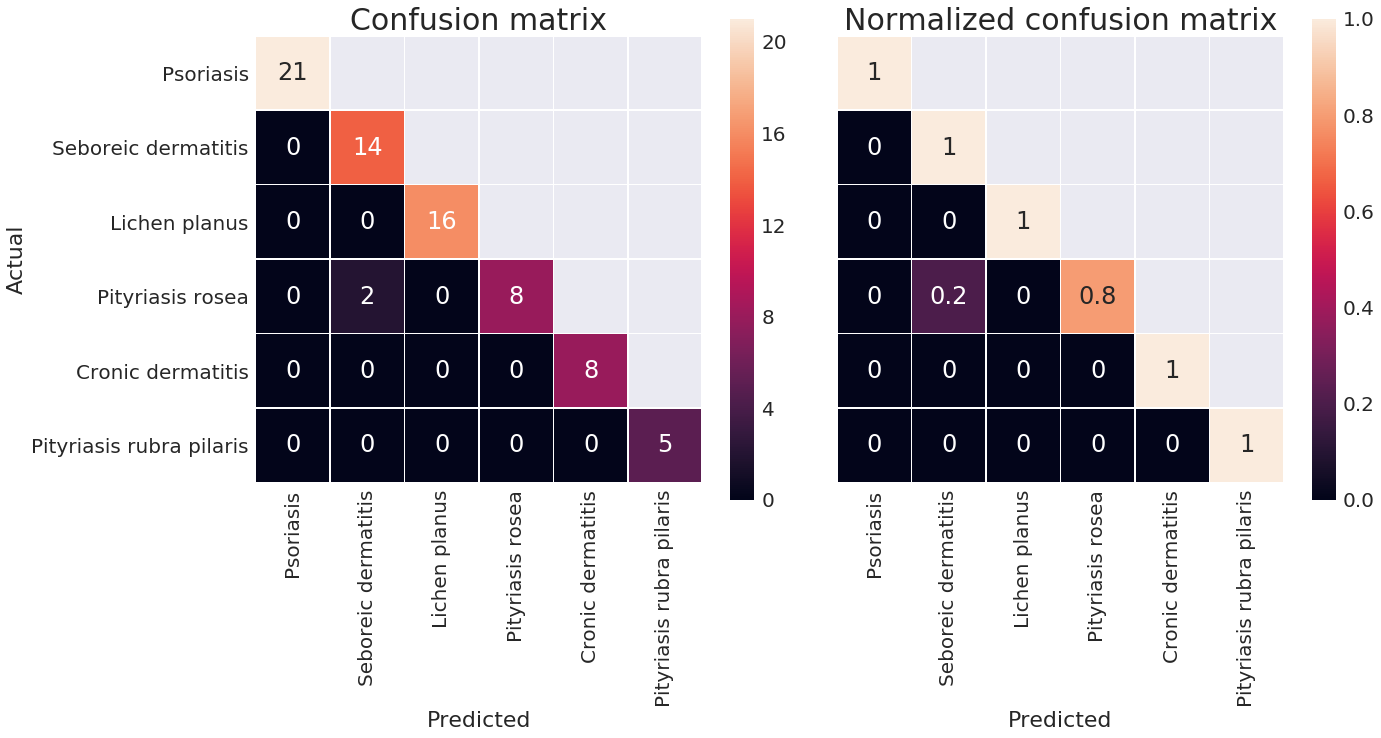

In [51]:
cnf_matrix = confusion_matrix(y_test_data, y_pred)
plot_confusion_matrix(cnf_matrix, classes=classes)

# Deep nueral network with Keras

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 500)               17500     
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               100200    
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 1206      
Total params: 118,906
Trainable params: 118,906
Non-trainable params: 0
_________________________________________________________________
None


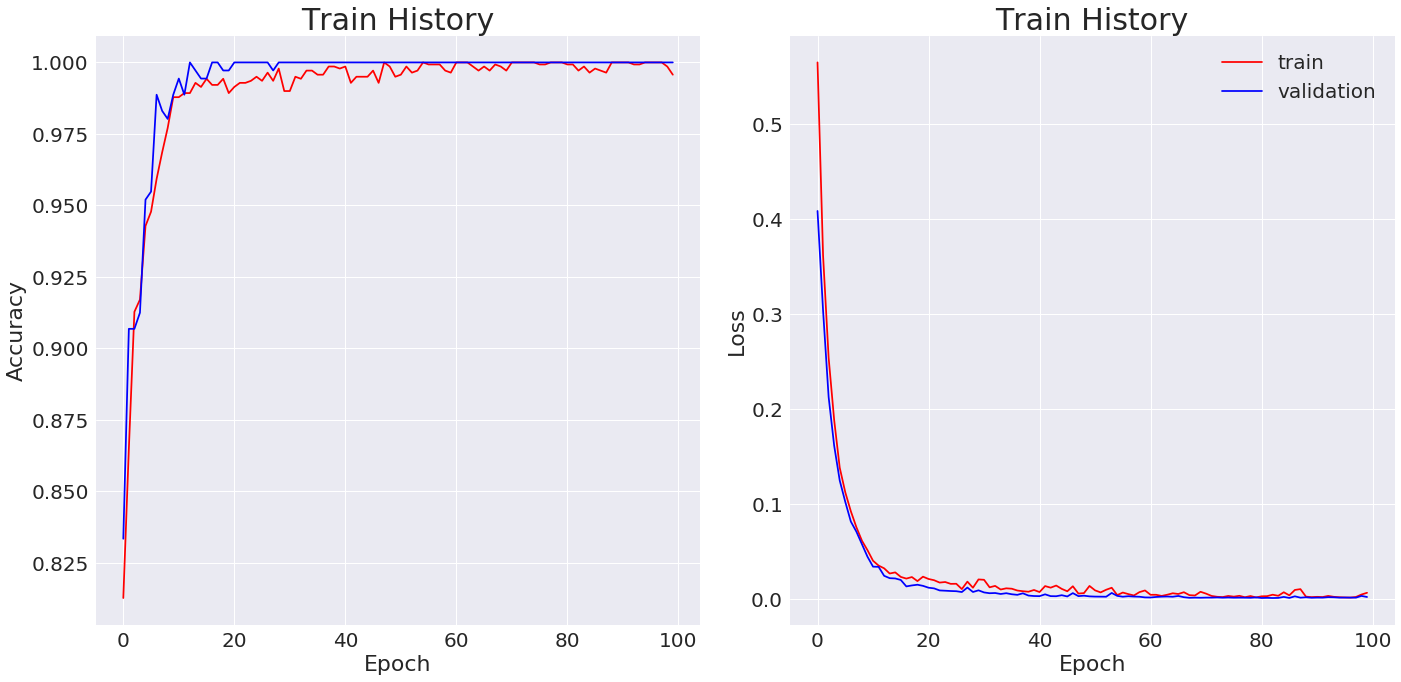

In [52]:
def show_train_history(train_history):    
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,10))

    sns.set(font_scale=2)
    ax1.plot(train_history.history['acc'],color = 'red')
    ax1.plot(train_history.history['val_acc'],color = 'blue')
    ax1.set_title('Train History', fontsize=30)
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='best')
    
    ax2.plot(train_history.history['loss'],color = 'red')
    ax2.plot(train_history.history['val_loss'],color = 'blue')
    ax2.set_title('Train History', fontsize=30)
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.tight_layout()    

######################### Model designing

model = Sequential() 

#Input layer
model.add(Dense(units=500, 
                input_dim=34, 
                kernel_initializer='uniform', 
                activation='relu'))
model.add(Dropout(0.5))

#Hidden layer 1
model.add(Dense(units=200,  
                kernel_initializer='uniform', 
                activation='relu'))
model.add(Dropout(0.5))

#Output layer
model.add(Dense(units=6,
                kernel_initializer='uniform', 
                activation='sigmoid'))

print(model.summary()) #for showing the structure and parameters

# Defining how to measure performance
model.compile(loss='binary_crossentropy',   
              optimizer='adam', metrics=['accuracy'])

encoder = LabelEncoder()
encoder.fit(y_data)
encoded_Y = encoder.transform(y_data)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)


# Train the model
# Verbose=2, showing loss and accuracy change timely
train_history = model.fit(x=x_data, y= dummy_y,  
                          validation_split=0.2, epochs=100, 
                          batch_size=10, verbose=0) 

#visualize the loss and accuracy after each epoch
show_train_history(train_history)


#For saving weights
#model.save_weights("Savemodels/Cervical_ca(Kaggles)_MLP.h5")
#print('model saved to disk')

In [53]:
y_pred = model.predict_classes(x_test_data) +1
accuracy = accuracy_score(y_test_data, y_pred);
print ('accuracy:%0.2f%%'%(accuracy*100))

accuracy:97.30%


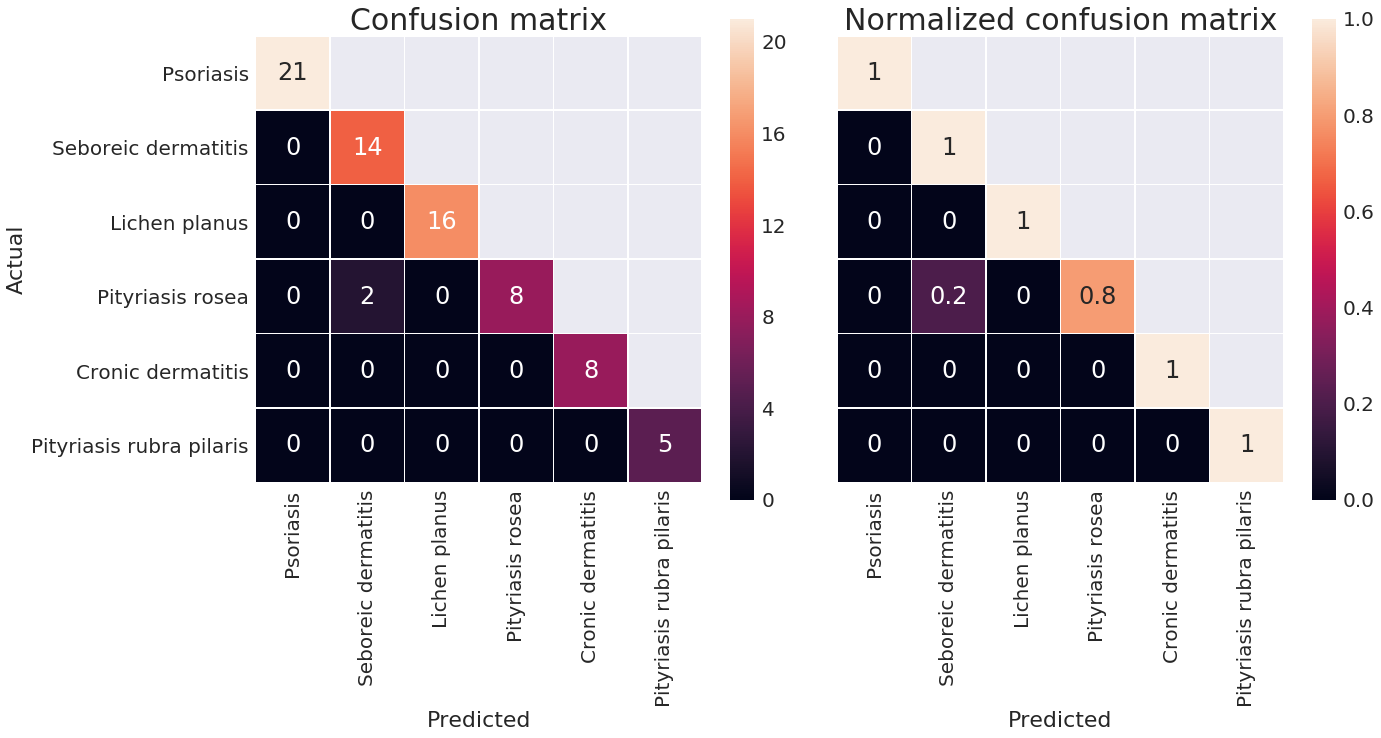

In [54]:
cnf_matrix = confusion_matrix(y_test_data, y_pred)
plot_confusion_matrix(cnf_matrix, classes=classes)

In [55]:
x_test_data[y_test_data!= y_pred]

,Erythema,Scaling,Sefinite borders,Itching,Koebner phenomenon,Polygonal papules,Follicular papules,Oral mucosal_involvement,Knee elbow involvement,Scalp involvement,Family history,Melanin incontinence,Eosinophils in the infiltrate,PNL infiltrate,Fibrosis of the papillary dermis,Exocytosis,acanthosis,Hyperkeratosis,Parakeratosis,Clubbing of the rete ridges,Elongation of the rete ridges,Thinning of the suprapapillary epidermis,Spongiform pustule,Munro microabcess,Focal hypergranulosis,Disappearance of the granular layer,Vacuolisation and damage of basal layer,Spongiosis,Saw-tooth appearance of retes,Follicular horn plug,Perifollicular parakeratosis,Inflammatory monoluclear inflitrate,Band-like infiltrate,Age
281,0.666667,0.666667,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.666667,0.666667,0.333333,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,0.0,0.0,0.0,0.666667,0.0,0.360000
41,0.333333,0.333333,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.333333,0.333333,0.000000,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,0.0,0.0,0.0,0.666667,0.0,0.826667


# Conclusion
Simply removing all rows which missing age, all the algorithm can achieve 100% accuracy. After filling missing ages with mean, median and mode of the age column, only SVM can reach accuracy score of 98.65% with only miss classify one pityriasis rosea case as seboreic dermatitis. Others, Random forest, ExtraTreesClassifier, and  Xgboost can reach accuracy score 97.30% by miss classify two of them. SVM outperforms other methods in this study, mainly because the dataset is linear, which make it easy to separate categories are divided by a clear gap. Accuracy can be improved further by accuracy ly imputing missing ages. One example is to use knn search to predict 8 missing data in Age column. 